# How to run hybrid CUDA-Q workloads on Amazon Braket

[CUDA-Q](https://nvidia.github.io/cuda-quantum/latest/index.html) offers a unified programming model designed for hybrid workloads that run on CPUs, GPUs and QPUs. In this notebook, we will explore how to run hybrid CUDA-Q programs on [Amazon Braket Hybrid Jobs](https://docs.aws.amazon.com/braket/latest/developerguide/braket-what-is-hybrid-job.html). Specifically, we will be using the [Bring Your Own Container (BYOC)](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-byoc.html) feature of Braket Hybrid Jobs. BYOC enables you to configure the environment that you want to use in your jobs.

<div class="alert alert-block alert-info"> 
    <b>Your task:</b> Verify the Jupyter kernel on the top right in this notebook to <code>docker_cudaq</code> before moving on to the next cells. 
</div>

In [ ]:
import os

os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

## CUDA-Q BYOC image

First, we have to prepare the environment for running a hybrid CUDA-Q workload in a container image.

We have already built an image for you and uploaded it to your private image repository on [Amazon Elastic Container Registry (ECR)](https://docs.aws.amazon.com/AmazonECR/latest/userguide/what-is-ecr.html). You may follow the link printed in the cell below which brings you to your image in the ECR console where you can verify it has the image URI printed further below.

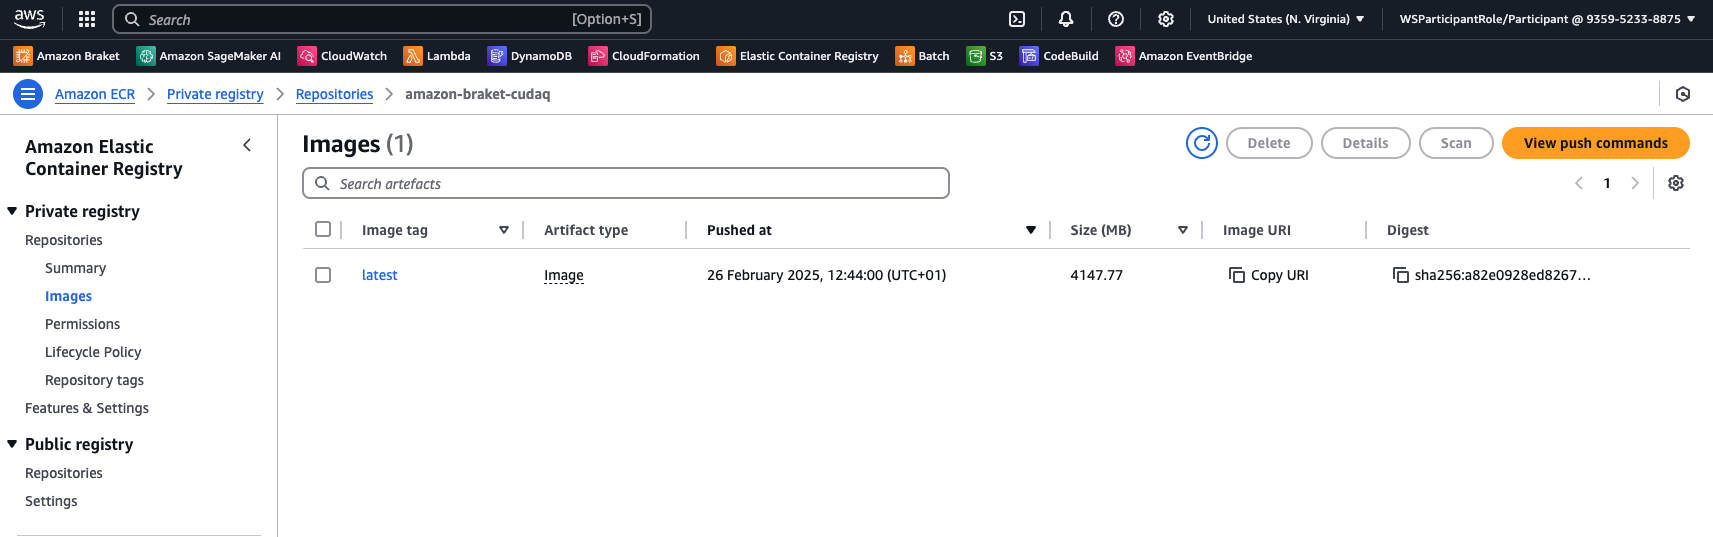

In [ ]:
import boto3

account_id = boto3.client('sts').get_caller_identity().get('Account')
aws_region = boto3.Session().region_name

print(f"https://{aws_region}.console.aws.amazon.com/ecr/repositories/private/{account_id}/amazon-braket-cudaq")

In [ ]:
image_uri = f"{account_id}.dkr.ecr.{aws_region}.amazonaws.com/amazon-braket-cudaq:latest"
print(image_uri)

Let's review the content of the Dockerfile we have built the image from:

```dockerfile
FROM 292282985366.dkr.ecr.us-east-1.amazonaws.com/amazon-braket-base-jobs:1.0-cpu-py310-ubuntu22.04-2025-02-15-18-01-26

ENV MPI_PATH=/usr/local

RUN apt-get update && apt-get upgrade -y
RUN pip install cudaq mpi4py
RUN bash /usr/local/lib/python3.10/site-packages/distributed_interfaces/activate_custom_mpi.sh

# Copying the hybrid jobs container entry point script from Amazon Braket examples
RUN mkdir -p /opt/ml/code
RUN git clone --depth=1 https://github.com/amazon-braket/amazon-braket-examples.git
RUN cp amazon-braket-examples/examples/nvidia_cuda_q/container/braket_container.py /opt/ml/code/braket_container.py
ENV SAGEMAKER_PROGRAM=braket_container.py
```

This is a simple, lightweight image where
1. we use the Braket pre-built base container image for Hybrid Jobs which comes with Python and OpenMPI
2. we install [cudaq](https://pypi.org/project/cudaq/) and [mpi4py](https://pypi.org/project/mpi4py/) modules
3. copy a Hybrid Jobs entry point script ([braket_container.py](/home/ec2-user/amazon-braket-examples/examples/nvidia_cuda_q/container/braket_container.py)) which makes available and executes the algorithm code we sent along when we start a job through the Braket [CreateJob](https://docs.aws.amazon.com/braket/latest/APIReference/API_CreateJob.html) API

For an example how you can build an image from this Dockerfile and upload the image to ECR, see this [example script](/home/ec2-user/amazon-braket-examples/examples/nvidia_cuda_q/container/container_build_and_push.sh). 

You may check that we have successfully built the image on [AWS CodeBuild](https://docs.aws.amazon.com/codebuild/latest/userguide/welcome.html) by following the link printed in below cell.

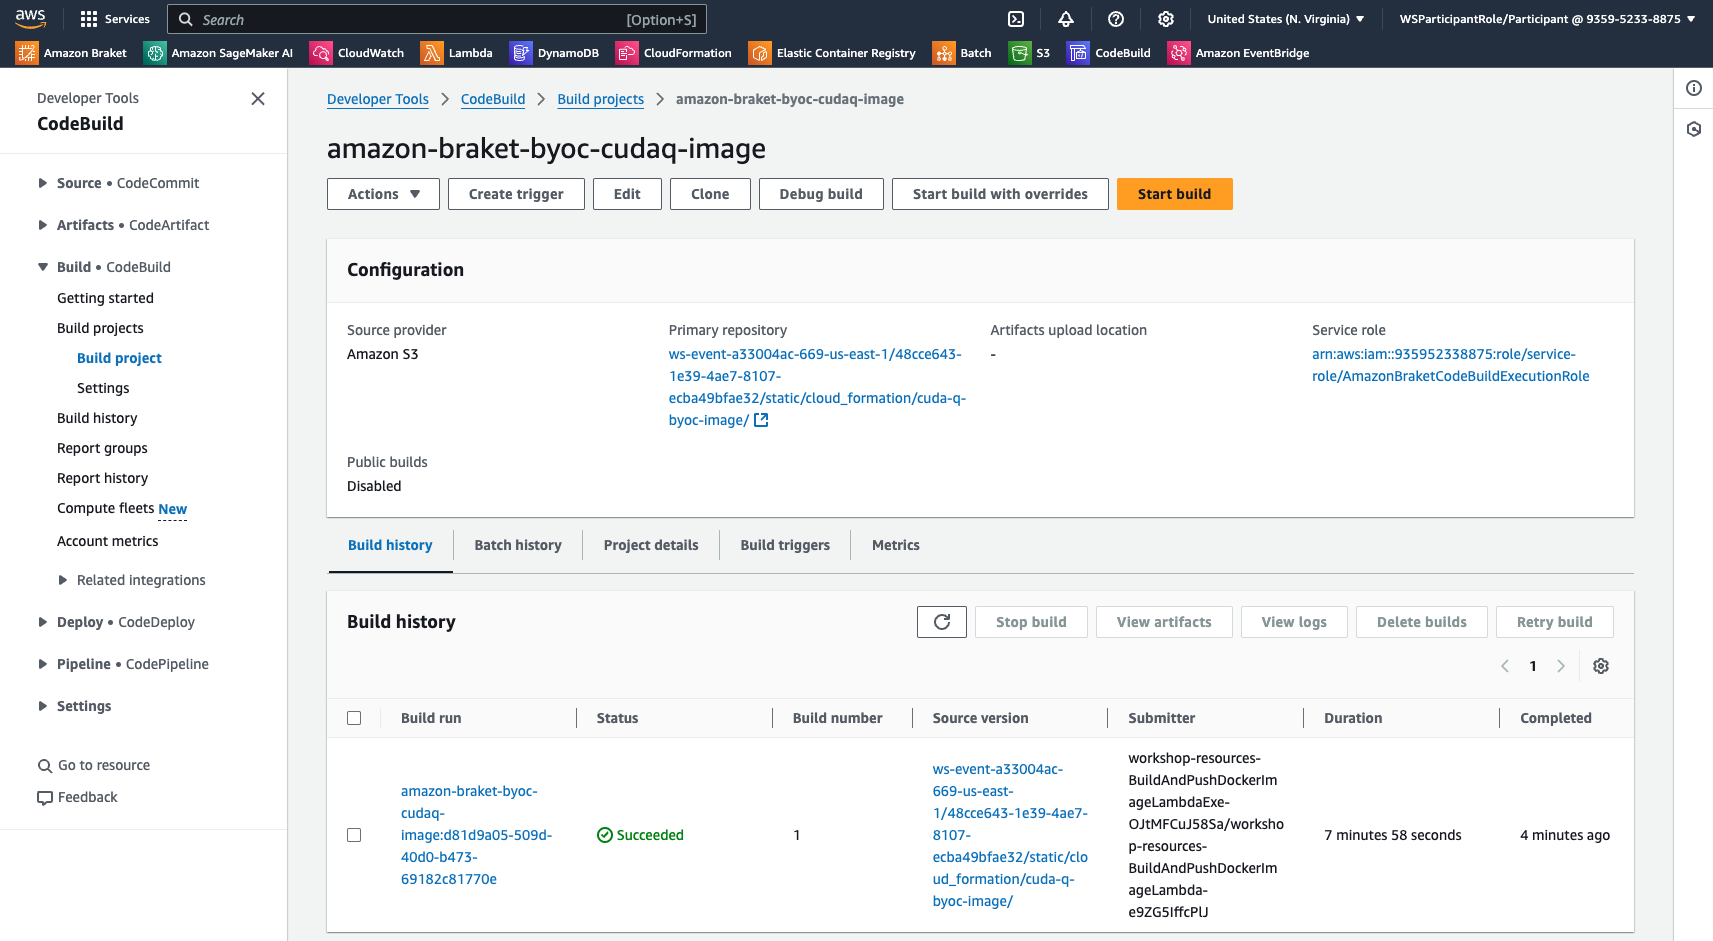

In [ ]:
print(f"https://{aws_region}.console.aws.amazon.com/codesuite/codebuild/{account_id}/projects/amazon-braket-byoc-cudaq-image/history")

## Build and test a CUDA-Q job locally

For a hybrid variational workload we take a basic [cost minimiztion example](https://nvidia.github.io/cuda-quantum/latest/applications/python/cost_minimization.html) from the CUDA-Q developer guide which involves flipping the Bloch vector of a qubit from the $|0\rangle$ to the $|1\rangle$ state.

In [ ]:
import cudaq
from typing import List

cudaq.set_target('qpp-cpu')

# Initialize a kernel/ ansatz and variational parameters.
@cudaq.kernel
def kernel(angles: List[float]):
    # Allocate a qubit that is initialized to the |0> state.
    qubit = cudaq.qubit()
    # Define gates and the qubits they act upon.
    rx(angles[0], qubit)
    ry(angles[1], qubit)


# Our Hamiltonian will be the Z expectation value of our qubit.
hamiltonian = cudaq.spin.z(0)

# Initial gate parameters which intialize the qubit in the zero state
initial_parameters = [0, 0]

print(cudaq.draw(kernel, initial_parameters))


# Cost function such that its minimal value corresponds to the qubit being in the state |1>.
cost_values = []
cost_fevs = 0
def cost(parameters):
    global cost_fevs
    cost_fevs += 1
    """Returns the expectation value as our cost."""
    expectation_value = cudaq.observe(kernel, hamiltonian,
                                      parameters).expectation()
    cost_values.append(expectation_value)
    print(f"  --> Cost function invocation: {cost_fevs} | expectation value: {expectation_value} | angles: {parameters}")
    return expectation_value


# We see that the initial value of our cost function is one, demonstrating that our qubit is in the zero state
print("Initial value of the cost function:")
initial_cost_value = cost(initial_parameters)

# Minimize the cost function using a built-in CUDA-Q optimizer.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = initial_parameters
optimizer.max_iterations = 5
print("Minimization...")
result = optimizer.optimize(dimensions=2, function=cost)

## Scale and run your job on Amazon Braket

Despite of the simple example, imagine we want to run such workloads at scale. Variational workloads may involve thousands of iterative tasks (i.e. CUDA-Q kernel executions). Alternatively, we may want to scan a certain parameter space and massively parallelize tasks. Apart from the quantum resource comsumption (both, simulator and QPU), we need a classical compute environment for the classical subroutines, interleaved, as well as pre- and prostprocessing steps, involved. Overall, a complete hybrid hero run may take several hours.

Amazon Braket provides a realiable, flexible, customizable and easy-to-use execution envionment named [Hybrid Jobs](https://docs.aws.amazon.com/braket/latest/developerguide/braket-what-is-hybrid-job.html) for running such hybrid workloads at scale.

Let's give it a try and explore how we can run the previous simulation as a hybrid job in the cloud.

In this first steps, we don't change anything related to the program execution. We even continue to use the same CUDA-Q target, `qpp-cpu`. But even in this case we already get a few benefits: A hybrid job is completely self-contained. The executed version of our algorithm code, the job configuration, potential hyperparameters and even input data are assoicated with the job entity and durably stored in the cloud. This enables rigid experiment tracking and reproduceablility for researchers. Running and monitoring a job is convenient. We don't have to worry about preserving a network connection or maintaining the compute environment. Creating a job is a fire-and-forget experience, while we get near real-time insights into algorithm metrics and logs. Using [checkpoints](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-checkpoints.html) you can save your job progress, interrupt and continue your job. Additionally, quantum tasks that are created from a hybrid job benefit from higher priority queueing to the target QPU device. This prioritization ensures that your quantum computations are processed and ran ahead of other tasks waiting in the queue.

In [ ]:
from braket.jobs import hybrid_job
from braket.jobs.environment_variables import get_job_device_arn
from braket.jobs.metrics import log_metric

cost_fevs = 0


@hybrid_job(device="local:cudaq/qpp-cpu", image_uri=image_uri)
def cudaq_job():
    import cudaq

    device = get_job_device_arn()
    cudaq.set_target(device.split("/")[-1])
    print(f"CUDA-Q backend: {cudaq.get_target().name}")

    # Initialize a kernel/ ansatz and variational parameters.
    @cudaq.kernel
    def kernel(angles: List[float]):
        # Allocate a qubit that is initialized to the |0> state.
        qubit = cudaq.qubit()
        # Define gates and the qubits they act upon.
        rx(angles[0], qubit)
        ry(angles[1], qubit)

    # Our Hamiltonian will be the Z expectation value of our qubit.
    hamiltonian = cudaq.spin.z(0)

    # Initial gate parameters which intialize the qubit in the zero state
    initial_parameters = [0, 0]

    print(cudaq.draw(kernel, initial_parameters))

    # Cost function such that its minimal value corresponds to the qubit being in the state |1>.
    global cost_fevs
    cost_fevs = 0

    def cost(parameters):
        global cost_fevs
        cost_fevs += 1
        """Returns the expectation value as our cost."""
        expectation_value = cudaq.observe(
            kernel,
            hamiltonian,
            parameters
        ).expectation()
        # instead of storing the cost values in a list, we create create a custom metric:
        log_metric(
            metric_name='cost_value',
            value=expectation_value,
            iteration_number=cost_fevs
        )
        return expectation_value

    # We see that the initial value of our cost function is one, demonstrating that our qubit is in the zero state
    print("Initial value of the cost function:")
    initial_cost_value = cost(initial_parameters)

    # Minimize the cost function using a built-in CUDA-Q optimizer.
    optimizer = cudaq.optimizers.COBYLA()
    optimizer.initial_parameters = initial_parameters
    print("Minimization...")
    result = optimizer.optimize(dimensions=2, function=cost)

    return result

In [ ]:
job = cudaq_job()
print(job)

You can look up your job on the [hybrid jobs page](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/jobs) in the Braket management console.

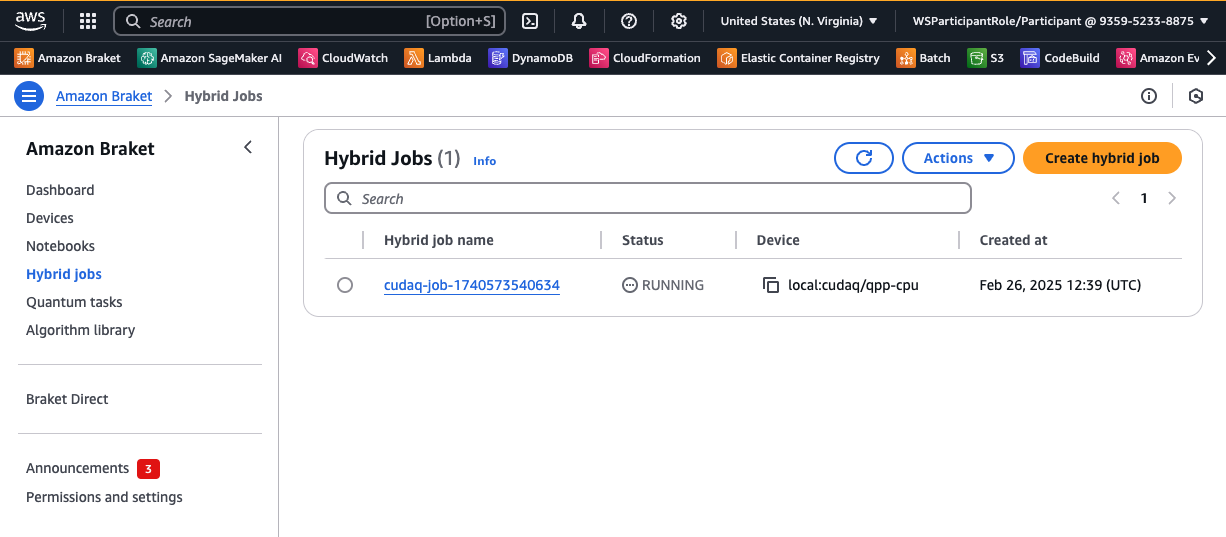

Once the job is running, we can monitor job metrics and console logs from the job page printed in the cell below:

In [ ]:
print(f"https://{aws_region}.console.aws.amazon.com/braket/home?region={aws_region}#/jobs/{job.arn}?tab=monitor")

### Job metadata

In [ ]:
print(f"Job state: {job.state()}\n")
print(f"Algorithm specification: {job.metadata()['algorithmSpecification']}\n")
print(f"Classical compute instance configuration: {job.metadata()['instanceConfig']}")

### Classical compute environment

As we created the job we didn't specify a classical compute environment. As you can see above, our algorithm ran in a container on one "ml.m5.large" instance, the default instance configuration for jobs. Below you see the different classical compute instances available to choose to run on:

| Instance Type    | vCPUs | Instance Memory (GiB) | GPU Model | GPUs | Total GPU Memory (GB) |
| ---------------- | ----- | --------------------- | --------- | ---- | --------------------- |
| ml.m5.large.     | 2     | 8                     |           |      |                       |
| ml.m5.xlarge     | 4     | 16                    |           |      |                       |
| ml.m5.2xlarge    | 8     | 32                    |           |      |                       |
| ml.m5.4xlarge    | 16    | 64                    |           |      |                       |
| ml.m5.12xlarge   | 58    | 192                   |           |      |                       |
| ml.m5.24xlarge   | 96    | 384                   |           |      |                       |
| ml.c5.xlarge     | 4     | 8                     |           |      |                       |
| ml.c5.2xlarge    | 8     | 16                    |           |      |                       |
| ml.c5.4xlarge    | 16    | 32                    |           |      |                       |
| ml.c5.9xlarge    | 36    | 72                    |           |      |                       |
| ml.c5.18xlarge   | 72    | 144                   |           |      |                       |
| ml.c5n.xlarge    | 4     | 10.5                  |           |      |                       |
| ml.c5n.2xlarge   | 8     | 21                    |           |      |                       |
| ml.c5n.4xlarge   | 16    | 42                    |           |      |                       |
| ml.c5n.9xlarge   | 36    | 96                    |           |      |                       |
| ml.c5n.18xlarge  | 72    | 192                   |           |      |                       |
| ml.p3.2xlarge    | 8     | 61                    | NVIDIA V100  | 1 | 16                    |
| ml.p3.8xlarge    | 32    | 244                   | NVIDIA V100  | 4 | 64                    |
| ml.p3.16xlarge   | 64    | 488                   | NVIDIA V100  | 8 | 128                   |
| ml.p3dn.24xlarge | 96    | 768                   | NVIDIA V100  | 8 | 256                   |
| ml.p4d.24xlarge  | 96    | 1152                  | NVIDIA A100  | 8 | 320                   |
| ml.g4dn.xlarge   | 4     | 16                    | NVIDIA T4    | 1 | 16                    |
| ml.g4dn.2xlarge  | 8     | 32                    | NVIDIA T4    | 1 | 16                    |
| ml.g4dn.4xlarge  | 16    | 64                    | NVIDIA T4    | 1 | 16                    |
| ml.g4dn.8xlarge  | 32    | 128                   | NVIDIA T4    | 1 | 16                    |
| ml.g4dn.12xlarge | 64    | 256                   | NVIDIA T4    | 1 | 16                    |
| ml.g4dn.16xlarge | 48    | 196                   | NVIDIA T4    | 4 | 64                    |
| ml.g5.xlarge     | 4     | 16                    | NVIDIA A10G  | 1 | 24                    |
| ml.g5.2xlarge    | 8     | 32                    | NVIDIA A10G  | 1 | 24                    |
| ml.g5.4xlarge    | 16    | 64                    | NVIDIA A10G  | 1 | 24                    |
| ml.g5.8xlarge    | 32    | 128                   | NVIDIA A10G  | 1 | 24                    |
| ml.g5.12xlarge   | 48    | 192                   | NVIDIA A10G  | 4 | 96                    |
| ml.g5.16xlarge   | 64    | 256                   | NVIDIA A10G  | 1 | 24                    |
| ml.g5.24xlarge   | 96    | 384                   | NVIDIA A10G  | 4 | 96                    |
| ml.g5.48xlarge   | 192   | 768                   | NVIDIA A10G  | 8 | 192                   |

Source: [Amazon SageMaker pricing page](https://aws.amazon.com/sagemaker-ai/pricing/)

In the example above, if we wanted to run on a different instance we could have specified the instance configuration in the `hybrid_job` decorator with

```python
from braket.jobs.config import InstanceConfig

@hybrid_job(
    device="local:cudaq/qpp-cpu", 
    image_uri=image_uri, 
    instance_config=InstanceConfig(instanceType="ml.m5.xlarge", instanceCount=2)
)
def cudaq_job():
    #
```

<div class="alert alert-block alert-info"> 
    <b>Note:</b> In the temporary AWS environments we are using here, we don't have quota for high performance instances, unfortunately. In your own AWS account, you can review your quota and request an increase on the <a href="https://us-east-1.console.aws.amazon.com/servicequotas/home/services/braket/quotas">Service Quotas management console</a>.
</div>

### Retrieve job results

In [ ]:
job_result = job.result()
print(f"Final cost value: {job_result['result'][0]}")
print(f"Optimal rotation angle for Rx: {job_result['result'][1][0]}")
print(f"Optimal rotation angle for Ry: {job_result['result'][1][1]}")

### Retrieve job metrics

In [ ]:
from braket.jobs.metrics_data.definitions import MetricType
import pandas as pd
import matplotlib.pyplot as plt

job_metrics = job.metrics(metric_type=MetricType.ITERATION_NUMBER)
if not job_metrics:
    print("Job metrics are not yet available. Please try later.")
else:
    df = pd.DataFrame(job_metrics)
    df.sort_values(by=["iteration_number"], inplace=True)

    plt.plot("iteration_number", "cost_value", data=df)
    plt.xlabel("Epochs")
    plt.ylabel("Cost Value")
    plt.show()

## Alternative job creation

The [`@hybrid_job`](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.jobs.hybrid_job.html#braket.jobs.hybrid_job.hybrid_job) decorator provides an convenient interface to submit a hybrid job, but it limits the availability of the source code to the inner functions defined in the decorator. The source code is critical for `@cudaq.kernel`. For more complex workloads, if you encounter an error related to the source code availability, you can choose to submit job without the [`@hybrid_job`](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.jobs.hybrid_job.html#braket.jobs.hybrid_job.hybrid_job) decorator and use [`AwsQuantumJob.create`](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.aws.aws_quantum_job.html#braket.aws.aws_quantum_job.AwsQuantumJob) instead.

To create a hybrid job using [`AwsQuantumJob.create`](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.aws.aws_quantum_job.html#braket.aws.aws_quantum_job.AwsQuantumJob), first you need to write your CUDA-Q program as a separate `.py` file. We will call this file the "algorithm script". For demo purpose, we have prepared an example algorithm script, [`algorithm_script.py`](./algorithm_script.py). Then, you can run the following code snippet to create the job. This interface of creating a hybrid job will not have any source code error. To learn more about creating hybrid job this way, you can read this [documentation page](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-first.html#braket-jobs-first-create) and this [example notebook](https://github.com/amazon-braket/amazon-braket-examples/tree/main/examples/hybrid_jobs/8_Creating_Hybrid_Job_Scripts).

In [ ]:
from pathlib import Path

base_path = Path('braket_workshops/SCA_2025/NVIDIA_tutorial/')
print(os.listdir(base_path))
module_path = Path(base_path, 'algorithm_script.py')

In [ ]:
from braket.aws import AwsQuantumJob, AwsDevice
from braket.devices import Devices

job = AwsQuantumJob.create(
    device="local:cudaq/qpp-cpu",
    source_module=module_path.as_posix(),
    image_uri=image_uri,
    hyperparameters={
        "n_shots": 1000,
        "max_iterations": 25,
    }
)
print(job)
print(f"https://{aws_region}.console.aws.amazon.com/braket/home?region={aws_region}#/jobs/{job.arn}?tab=events")

### Retrieve job results

In [ ]:
import numpy as np

job_result = job.result()
print(f"Final cost value: {job_result['result'][0]}")
print(f"Optimal rotation angle for Rx: {job_result['result'][1][0]}")
print(f"Optimal rotation angle for Ry: {job_result['result'][1][1]}")

job_metrics = job.metrics(metric_type=MetricType.ITERATION_NUMBER)
if not job_metrics:
    print("Job metrics are not yet available. Please try later.")
else:
    df = pd.DataFrame(job_metrics)
    df.sort_values(by=["iteration_number"], inplace=True)

    fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
    fig.set_figwidth(15)
    fig.suptitle("Job metrics", size=16, y=0.99)

    ax1.axhline(y=1, color='black', linestyle='--')
    ax1.axhline(y=-1, color='black', linestyle='--')
    ax1.plot("iteration_number", "cost_value", data=df)
    ax1.set_xlabel('epochs', fontsize=14)
    ax1.set_ylabel(r'$\langle Z\rangle$', fontsize=14, rotation=90, labelpad=-5)
    ax1.set_xlim([-1, 27])

    ax2.axhline(y=np.pi, color='black', linestyle='--')
    ax2.axhline(y=0, color='black', linestyle='--')
    ax2.plot("iteration_number", "rx_angle", data=df)
    ax2.set_xlabel('epochs', fontsize=14)
    ax2.set_ylabel(r'$\theta_x$', fontsize=14, rotation=90, labelpad=-5)
    ax2.set_xlim([-1, 27])

    ax3.axhline(y=np.pi, color='black', linestyle='--')
    ax3.axhline(y=0, color='black', linestyle='--')
    ax3.plot("iteration_number", "ry_angle", data=df)
    ax3.set_xlabel('epochs', fontsize=14)
    ax3.set_ylabel(r'$\theta_y$', fontsize=14, rotation=90, labelpad=0)
    ax3.set_xlim([-1, 27])

    plt.show()

## Run on quantum hardware

Let's run this variational algorithm on real quantum hardware. Remember that Braket Hybrid Jobs provides better performance than running the algorithms from your own environment. While your job is running, it has priority access to the selected target QPU. This means that tasks from your job run ahead of other tasks queued on the device. This results in shorter and more predictable runtimes for hybrid algorithms.

In [ ]:
qpu = Devices.Rigetti.Ankaa3
qpu_region = AwsDevice.get_device_region(qpu)

qpu_job = AwsQuantumJob.create(
    device=qpu,
    source_module=module_path.as_posix(),
    image_uri=f"{account_id}.dkr.ecr.{qpu_region}.amazonaws.com/amazon-braket-cudaq:latest",
    hyperparameters={
        "n_shots": 1000,
        "max_iterations": 25,
    }
)
print(qpu_job)
print(f"https://{qpu_region}.console.aws.amazon.com/braket/home?region={qpu_region}#/jobs/{qpu_job.arn}?tab=events")

### When will my job run?

In [ ]:
qpu_job.queue_position()

### Retrieve QPU job results

In [ ]:
job_result = qpu_job.result()
print(f"Final cost value: {job_result['result'][0]}")
print(f"Optimal rotation angle for Rx: {job_result['result'][1][0]}")
print(f"Optimal rotation angle for Ry: {job_result['result'][1][1]}")

job_metrics = qpu_job.metrics(metric_type=MetricType.ITERATION_NUMBER)
if not job_metrics:
    print("Job metrics are not yet available. Please try later.")
else:
    df = pd.DataFrame(job_metrics)
    df.sort_values(by=["iteration_number"], inplace=True)

    fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
    fig.set_figwidth(15)
    fig.suptitle("Job metrics", size=16, y=0.99)

    ax1.axhline(y=1, color='black', linestyle='--')
    ax1.axhline(y=-1, color='black', linestyle='--')
    ax1.plot("iteration_number", "cost_value", data=df)
    ax1.set_xlabel('epochs', fontsize=14)
    ax1.set_ylabel(r'$\langle Z\rangle$', fontsize=14, rotation=90, labelpad=-5)
    ax1.set_xlim([-1, 27])

    ax2.axhline(y=np.pi, color='black', linestyle='--')
    ax2.axhline(y=0, color='black', linestyle='--')
    ax2.plot("iteration_number", "rx_angle", data=df)
    ax2.set_xlabel('epochs', fontsize=14)
    ax2.set_ylabel(r'$\theta_x$', fontsize=14, rotation=90, labelpad=-5)
    ax2.set_xlim([-1, 27])

    ax3.axhline(y=np.pi, color='black', linestyle='--')
    ax3.axhline(y=0, color='black', linestyle='--')
    ax3.plot("iteration_number", "ry_angle", data=df)
    ax3.set_xlabel('epochs', fontsize=14)
    ax3.set_ylabel(r'$\theta_y$', fontsize=14, rotation=90, labelpad=0)
    ax3.set_xlim([-1, 27])

    plt.show()

Let's look up the individual quantum tasks we have created within the hybrid job:

In [ ]:
qpu_job_tasks = boto3.client("braket", region_name=qpu_region).search_quantum_tasks(
    filters=[{'name': 'jobArn', 'operator': 'EQUAL', 'values': [qpu_job.arn]}],
    maxResults=100
)['quantumTasks']

task_price = 0.3
shot_price = AwsDevice(qpu).properties.service.deviceCost.price

print("QPU tasks:")
total_tasks = len(qpu_job_tasks)
total_shots = 0
for qpu_job_task in qpu_job_tasks:
    total_shots += qpu_job_task['shots']
    print(qpu_job_task['quantumTaskArn'])

print("--------------------------------------------")
print(f"Total number of tasks on QPU: {total_tasks}")
print(f"Total number of shots on QPU: {total_shots}")
print(f"Total on-demand QPU resource cost: ${task_price * total_tasks + shot_price * total_shots}")

You can get all task information and metadata, including the compiled program executed on the QPU using the `AwsQuantumTask` object, as we have done previously in the first lab.

## Conclusion

<div class="alert alert-block alert-info"> 
    <b>Congratulations</b>, you have successfully flipped a qubit from the $|0\rangle$ to the $|1\rangle$ state with a hybrid variational algorithm coded up with CUDA-Q and executed as a hybrid job on Amazon Braket accessing Rigetti's Ankaa 3 QPU.
</div>

To continue learning about Amazon Braket we encourage you to check out the following resources:
* [Amazon Braket Examples](https://github.com/amazon-braket/amazon-braket-examples): Our primary repository for code examples on GitHub with Jupyter notebooks covering introductory level code snippets, advanced service features and reference implementations of canonical routines and example algorithms.
* [Amazon Braket Labs](https://github.com/amazon-braket/amazon-braket-labs): A GitHub repository highlighting community contributions and community-driven projects such as frameworks, examples, experimental components, and tools built on top of Braket.
* [Amazon Braket Digital Course](https://explore.skillbuilder.aws/learn/learning_plan/view/1990/amazon-braket-knowledge-badge-readiness-path-amazon): Our self-service learning path helping you build the knowledge and technical skills to use Amazon Braket, including domain-specific content, knowledge checks, hands-on labs and a knowledge badge assessment delivered on demand on AWS Skill Builder.
* [AWS Quantum Technologies Blog Channel](https://aws.amazon.com/blogs/quantum-computing/): Stay in the know with new features, service announcements and news from the community and our customers and partners.
* [Quantum Embark](https://aws.amazon.com/blogs/quantum-computing/aws-announces-the-quantum-embark-program-to-help-customers-get-ready-for-quantum-computing/): If you are a customer seeking trustworthy information about the relevance of quantum technology to your most important use cases, to understand the current state-of-play, and make informed decisions about when is the right time to engage, check out our Quantum Embark Program.

<div class="alert alert-block alert-success">
    <b>Remember</b> that we will have to terminate the workshop environments end of today. If you want to keep this tutorial content for your own reference, we recommend you download the zip archive from the file browser on the left to your notebook.
</div>